## SHAP

In [1]:
import os
import pickle
import torch
from model import DelphiConfig, Delphi
from tqdm import tqdm
import pandas as pd
import numpy as np
import textwrap
import warnings


import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})
plt.rcParams['figure.dpi']= 72
plt.rcParams['pdf.fonttype'] = 42

delphi_labels = pd.read_csv('delphi_labels_chapters_colours_icd.csv')
labels = pd.read_csv("data/ukb_simulated_data/labels.csv", header=None, sep="\t")

In [51]:
!pwd

/omics/groups/OE0606/internal/art1m/projects/nanoGPT/Delphi_repo_himeji


## Load model

In [2]:
out_dir = 'Delphi-2M'
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype ='float32' #'bfloat16' # 'float32' or 'bfloat16' or 'float16'
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = {'float32': torch.float32, 'float64': torch.float64, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

In [3]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
conf = DelphiConfig(**checkpoint['model_args'])
model = Delphi(conf)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

model.eval()
model = model.to(device)

number of parameters: 2.24M


In [4]:
checkpoint['model_args']

{'n_layer': 12,
 'n_head': 12,
 'n_embd': 120,
 'block_size': 48,
 'bias': False,
 'vocab_size': 1270,
 'dropout': 0.0,
 'token_dropout': 0.0,
 't_min': 0.1,
 'mask_ties': True,
 'ignore_tokens': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

## Load data

In [5]:
from utils import get_batch, get_p2i

In [6]:
train = np.fromfile('data/ukb_simulated_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('data/ukb_simulated_data/val.bin', dtype=np.uint32).reshape(-1,3)

train_p2i = get_p2i(train)
val_p2i = get_p2i(val)

In [7]:
person = [('Male', 0),
 ('B01 (varicella [chickenpox])',2),
 ('L20 (atopic dermatitis)',3),
 ('Healthy', 5),
 ('Healthy', 10),
 ('Healthy', 15),
 ('Healthy', 20),
 ('G43 (migraine)', 20),
 ('E73 (lactose intolerance)',21),
 ('B27 (infectious mononucleosis)',22),
 ('Healthy', 25),
 ('J11 (influenza, virus not identified)',28),
 ('Healthy', 30),
 ('Healthy', 35),
 ('C25 Malignant neoplasm of pancreas',38),
 ('Healthy', 40),
 ('Smoking_low', 41),
 ('BMI_mid', 41),
 ('Alcohol_high', 41),
 ('Healthy', 42),
]
person = [(a, b * 365.25) for a,b in person] 

### Individual SHAP values

In [8]:
id_to_token = labels.to_dict()[0]
token_to_id = {v:k for k, v in id_to_token.items()}

def tokens_to_ids(tokens):
    return [token_to_id[t] for t in tokens]

def ids_to_tokens(ids):
    return [id_to_token[int(id_)] for id_ in ids]

def split_person(p):
    tokens = [i[0] for i in p]
    ages = [i[1] for i in p]
    return tokens, ages

In [9]:
def get_person(idx):
    x, y, _, time = get_batch([idx], val, val_p2i,  
              select='smart_random', block_size=48, 
              device=device, padding='random')
    x, y = x[y > -1], y[y > -1]
    person = []
    for token_id, date in zip(x, y):
        person.append((id_to_token[token_id.item()], date.item()))
    return person, y, time[0][-1]

In [10]:
from itertools import takewhile
from utils import shap_custom_tokenizer, shap_model_creator
import shap

# person_to_process = get_person(137)[0]
person_to_process = person
diseases_of_interest = [1269, 46, 95, 1168, 374, 173, 214, 305, 505, 584]

person_tokens, person_ages = split_person(person_to_process)
person_tokens_ids = tokens_to_ids(person_tokens)

masker = shap.maskers.Text(shap_custom_tokenizer, output_type='str', mask_token='10000', collapse_mask_token=False)
model_shap = shap_model_creator(model, diseases_of_interest, person_tokens_ids, person_ages, device)
explainer = shap.Explainer(model_shap, masker, output_names=delphi_labels['name'].values[diseases_of_interest])

shap_values = explainer([' '.join(list(map(lambda x: str(token_to_id[x]), person_tokens)))])
shap_values.data = np.array([list(map(lambda x: f"{delphi_labels['name'].values[token_to_id[x[0]]]}({x[1]/365:.1f} years) ", person_to_process))])

In [11]:
out = shap.plots.text(shap_values, display=True)

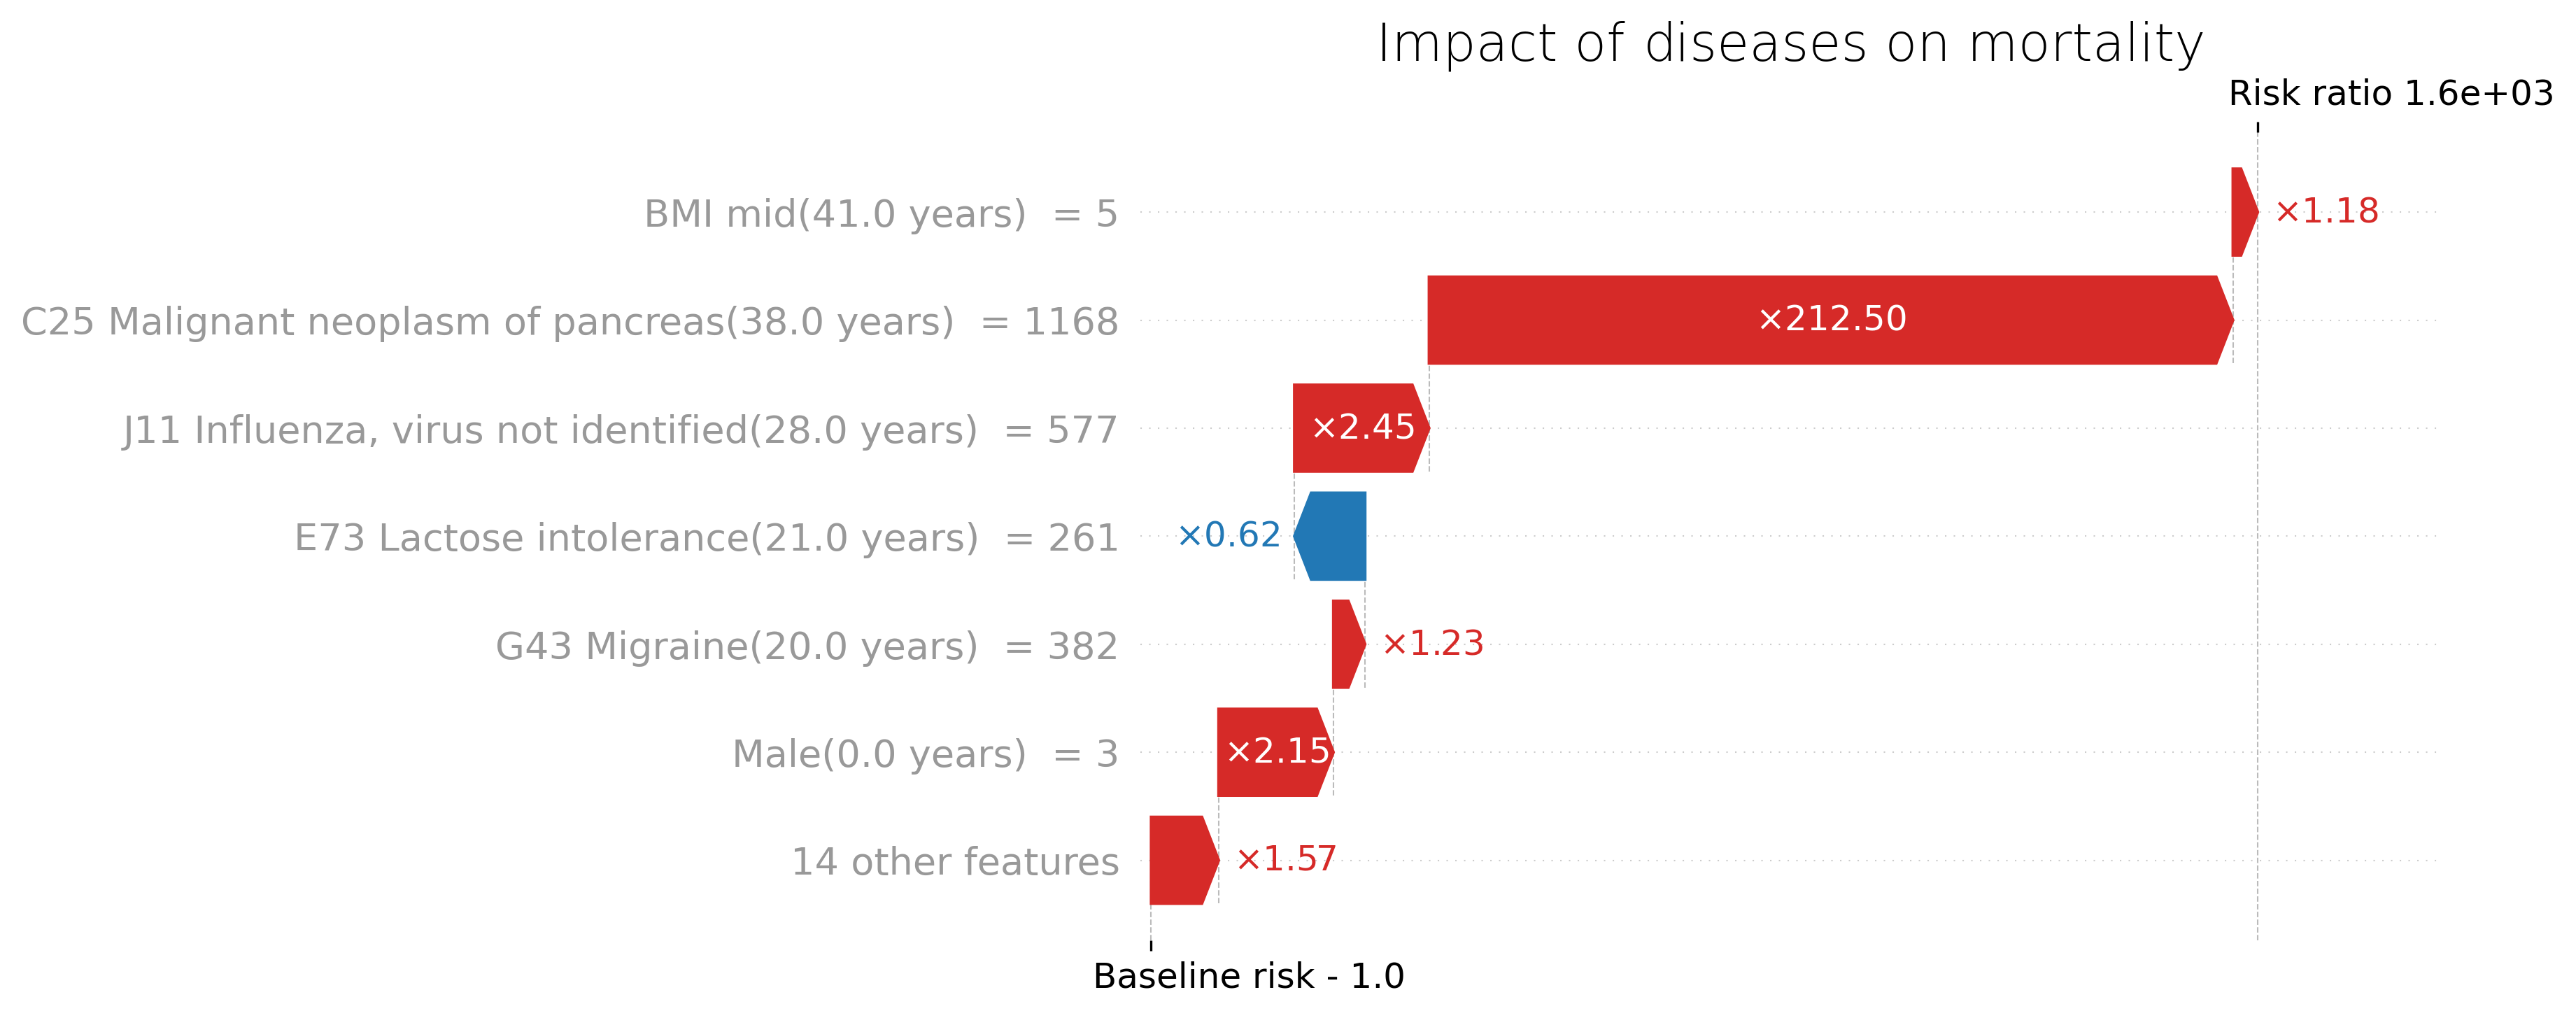

In [12]:
from plotting import waterfall

with plt.style.context('default'):
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['font.size'] = 4
    waterfall(shap_values[0, ..., 0], max_display=7, show=False, ages=person_ages)
    plt.gca().set_title('Impact of diseases on mortality', fontweight=1, size=18)
    plt.show()

## Pre-computed many cases

The small synthetic dataset is not enough to properly run following part; if you have access to the full dataset, the `shap-agg-eval.py` to evaluate SHAP values for the entire dataset.

In [13]:
import pickle

with open('shap_agg_synthetic.pickle', 'rb') as f:
    shap_pkl = pickle.load(f)
    
all_tokens = shap_pkl['tokens']
all_values = shap_pkl['values']

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_shap = pd.DataFrame(all_values)
df_shap['token'] = all_tokens.astype('int')

In [15]:
token_count_dict = df_shap['token'].value_counts().sort_index().to_dict()

N_min = 5

columns_more_N = [c for c in df_shap.columns if c == 1269 or (c in token_count_dict and token_count_dict[c] >= N_min)]
df_shap_agg = df_shap[df_shap['token'].apply(lambda x: token_count_dict[x] > N_min)].groupby('token').mean()

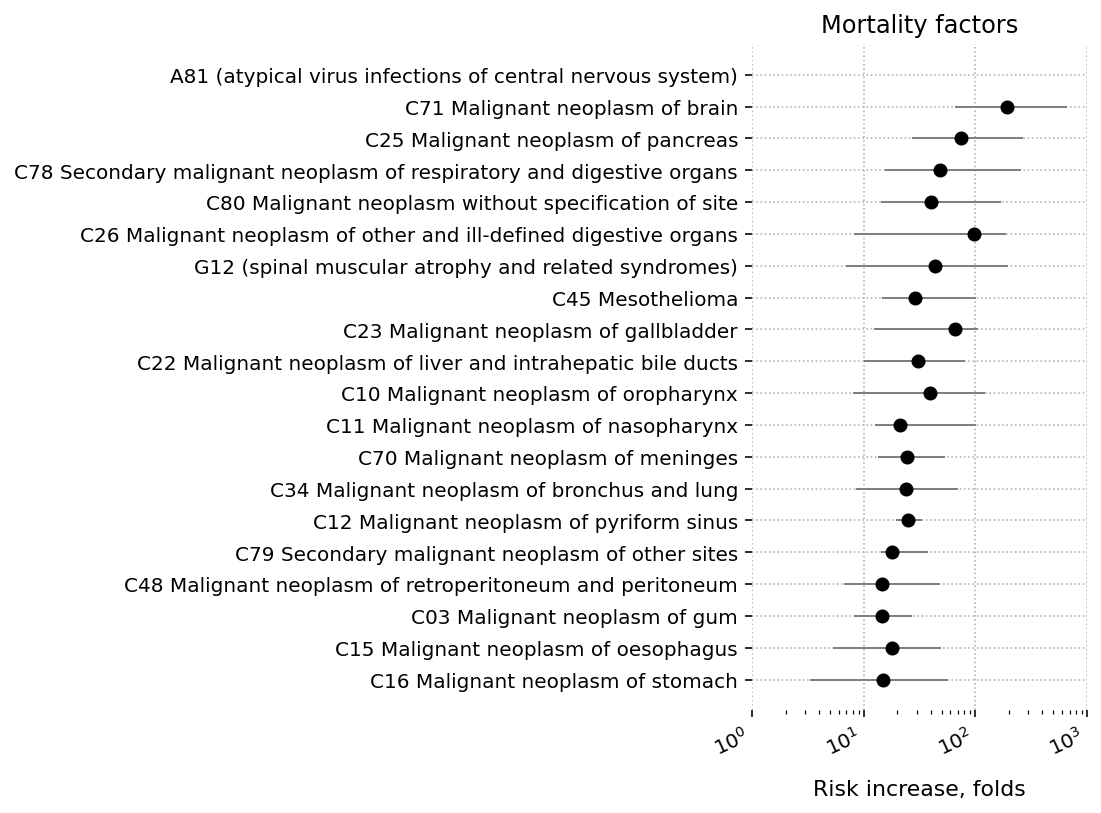

In [16]:
import matplotlib.pyplot as plt
import numpy as np

N = 1269
n_first = 20
positive = True

# Determine the most probable tokens and values based on the condition
if positive:
    most_probable_tokens = df_shap_agg[N].nlargest(n_first).index[::-1]
    most_probable_values = df_shap_agg[N].nlargest(n_first).values[::-1]
else:
    most_probable_tokens = df_shap_agg[N].nsmallest(n_first).index[::-1]
    most_probable_values = df_shap_agg[N].nsmallest(n_first).values[::-1]

# Prepare the data
df_shap_selected_melted = df_shap[df_shap['token'].isin(most_probable_tokens)][[N, 'token']].reset_index(drop=True).melt(id_vars=['token'])
df_shap_selected_melted['token'] = df_shap_selected_melted['token'].map(id_to_token)
df_shap_selected_melted['value'] = np.exp(df_shap_selected_melted['value'])

# Create a figure and axis
plt.figure(figsize=(3, 6), facecolor='w')
ax = plt.gca()

# Map most_probable_tokens to their string representations
token_strings = [id_to_token[token] for token in most_probable_tokens]

# Plot median and quartiles for each token
for i, token in enumerate(token_strings):
    data = df_shap_selected_melted[df_shap_selected_melted['token'] == token]['value']
    median = np.median(data)
    quartiles = np.percentile(data, [25, 75])
    
    # Plot median
    if i == len(token_strings) - 1:
        ax.plot(median, i, 'o', color='red', zorder=3)
    else:
        ax.plot(median, i, 'o', color='black', zorder=3)
    
    # Plot quartiles
    ax.hlines(i, quartiles[0], quartiles[1], color='gray', linestyles='solid', linewidth=1)

# Set title and labels
positive_text = "" if positive else "not "
title_text = f'Mortality factors'
plt.title(title_text)
plt.yticks(range(len(token_strings)), token_strings)

# Adjust x-ticks orientation
plt.xticks(rotation=25, ha='right')
plt.xscale('log')
plt.xlim(1, 1000)
plt.xlabel('Risk increase, folds', size=11, labelpad=10)

# Show the plot
plt.show()

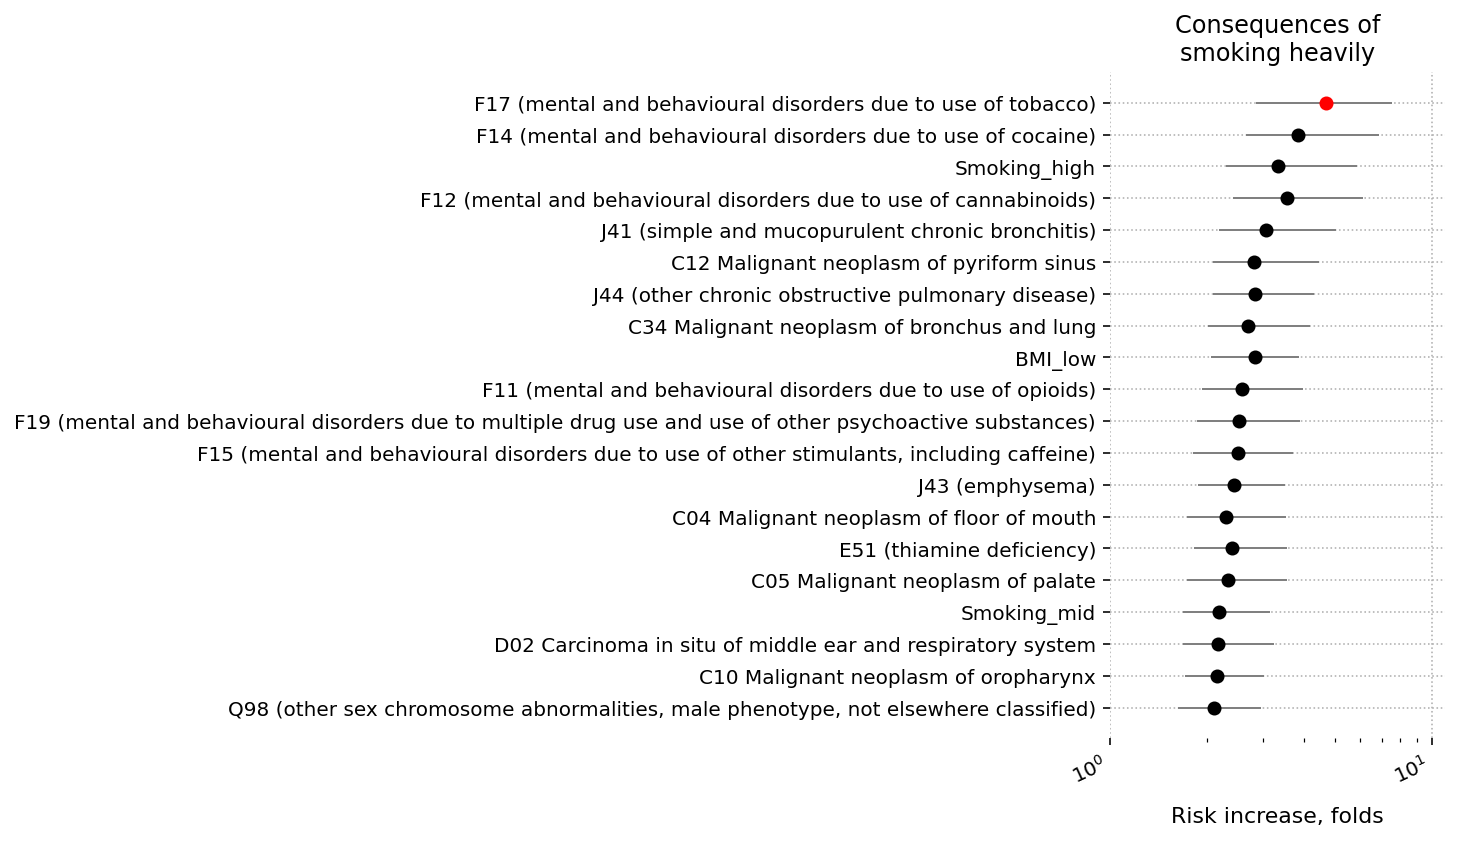

In [17]:
import matplotlib.pyplot as plt
import numpy as np

N = 9
n_first = 20
positive = True

# Determine the most probable tokens and values based on the condition
if positive:
    most_probable_tokens = df_shap_agg.loc[N].argsort()[::-1][:n_first][::-1]
else:
    most_probable_tokens = df_shap_agg.loc[N].argsort()[:n_first][::-1]


# Prepare the data
df_shap_selected_melted = df_shap[df_shap['token'] == N][[*most_probable_tokens, 'token']].reset_index(drop=True).melt(id_vars=['token'])
df_shap_selected_melted['token'] = df_shap_selected_melted['token'].map(id_to_token)
df_shap_selected_melted['variable'] = df_shap_selected_melted['variable'].map(id_to_token)

df_shap_selected_melted['value'] = np.exp(df_shap_selected_melted['value'])

# Create a figure and axis
plt.figure(figsize=(3, 6), facecolor='w')
ax = plt.gca()

# Map most_probable_tokens to their string representations
token_strings = [id_to_token[token] for token in most_probable_tokens]

# Plot median and quartiles for each token
for i, token in enumerate(token_strings):
    data = df_shap_selected_melted[df_shap_selected_melted['variable'] == token]['value']
    median = np.median(data)
    quartiles = np.percentile(data, [25, 75])
    
    # Plot median
    if i == len(token_strings) - 1:
        ax.plot(median, i, 'o', color='red', zorder=3)
    else:
        ax.plot(median, i, 'o', color='black', zorder=3)
    
    # Plot quartiles
    ax.hlines(i, quartiles[0], quartiles[1], color='gray', linestyles='solid', linewidth=1)

# Set title and labels
title_text = 'Consequences of\nsmoking heavily'
plt.title(title_text)
plt.yticks(range(len(token_strings)), token_strings)

# Adjust x-ticks orientation
plt.xticks(rotation=25, ha='right')
plt.xscale('log')
plt.xlim(1, 11)
plt.xlabel('Risk increase, folds', size=11, labelpad=10)

# Show the plot
plt.show()


### Influence vs Predictability

In [18]:
df_shap_agg_sim = df_shap_agg[df_shap_agg.index].values[13:, 13:]
perm = np.arange(df_shap_agg_sim.shape[0])
np.random.shuffle(perm)
df_shap_agg_sim = df_shap_agg_sim[perm][:, perm]

In [19]:
df_shap_agg_sim_x = df_shap_agg_sim[np.triu_indices(df_shap_agg_sim.shape[0], 1)]
df_shap_agg_sim_y = df_shap_agg_sim.T[np.triu_indices(df_shap_agg_sim.shape[0], 1)]
corrcoef = np.corrcoef(df_shap_agg_sim_y, df_shap_agg_sim_x)[0, 1]

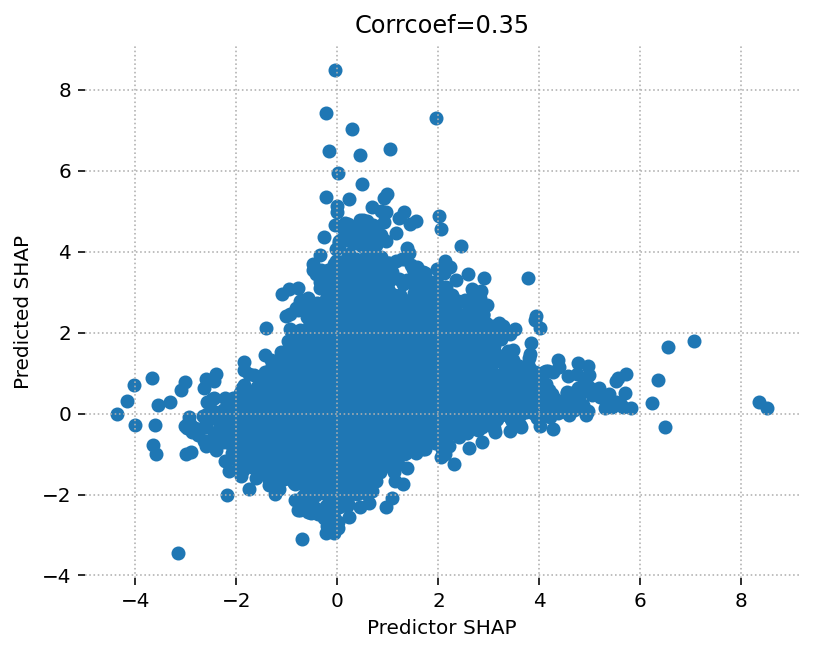

In [20]:
from matplotlib.colors import LogNorm

ddf = pd.DataFrame({'x': df_shap_agg_sim_x, 'y': df_shap_agg_sim_y})

plt.scatter(df_shap_agg_sim_x, df_shap_agg_sim_y)

plt.xlabel('Predictor SHAP')
plt.ylabel('Predicted SHAP')
plt.title(f'Corrcoef={corrcoef:.2f}')
plt.show()

#### Only within chapters

In [21]:
df_shap_agg_sim_x_all = []
df_shap_agg_sim_y_all = []
colours = []
coeffs = []
chapters = []

for g, df_ in delphi_labels.groupby('ICD-10 Chapter (short)'):
    if g in ['Sex', 'Smoking, Alcohol and BMI']:
        continue
    idxs = np.intersect1d(df_shap_agg.index.values, df_.index.values)
    df_shap_agg_sim = df_shap_agg.loc[idxs, idxs].values
    df_shap_agg_sim_x = df_shap_agg_sim[np.triu_indices(df_shap_agg_sim.shape[0], 1)]
    df_shap_agg_sim_y = df_shap_agg_sim.T[np.triu_indices(df_shap_agg_sim.shape[0], 1)]

    df_shap_agg_sim_x_all.append(df_shap_agg_sim_x)
    df_shap_agg_sim_y_all.append(df_shap_agg_sim_y)
    colours += [df_['color'].values[0]] * len(df_shap_agg_sim_x)
    chapters += [g] * len(df_shap_agg_sim_x)

    coef = np.corrcoef(df_shap_agg_sim_x, df_shap_agg_sim_y)[0, 1]
    if not np.isnan(coef):
        coeffs.append(coef)
    print(f'{g}\t {coef:.2f}')

df_shap_agg_sim_x = np.concatenate(df_shap_agg_sim_x_all)
df_shap_agg_sim_y = np.concatenate(df_shap_agg_sim_y_all)

Death	 nan
I. Infectious Diseases	 0.23
II. Neoplasms	 0.45
III. Blood & Immune Disorders	 0.66
IV. Metabolic Diseases	 0.49
IX. Circulatory Diseases	 0.56
Technical	 nan
V. Mental Disorders	 0.58
VI. Nervous System Diseases	 0.54
VII. Eye Diseases	 0.52
VIII. Ear Diseases	 0.82
X. Respiratory Diseases	 0.52
XI. Digestive Diseases	 0.61
XII. Skin Diseases	 0.49
XIII. Musculoskeletal Diseases	 0.60
XIV. Genitourinary Diseases	 0.68
XV. Pregnancy & Childbirth	 0.16
XVI. Perinatal Conditions	 0.50
XVII. Congenital Abnormalities	 0.50


Mean of empty slice.
invalid value encountered in divide
Degrees of freedom <= 0 for slice
divide by zero encountered in divide
invalid value encountered in multiply
Mean of empty slice.
invalid value encountered in divide
Degrees of freedom <= 0 for slice
divide by zero encountered in divide
invalid value encountered in multiply


In [22]:
color_mapping = {}
for ch, col in delphi_labels[['ICD-10 Chapter (short)', 'color']].values:
    color_mapping[ch] = col

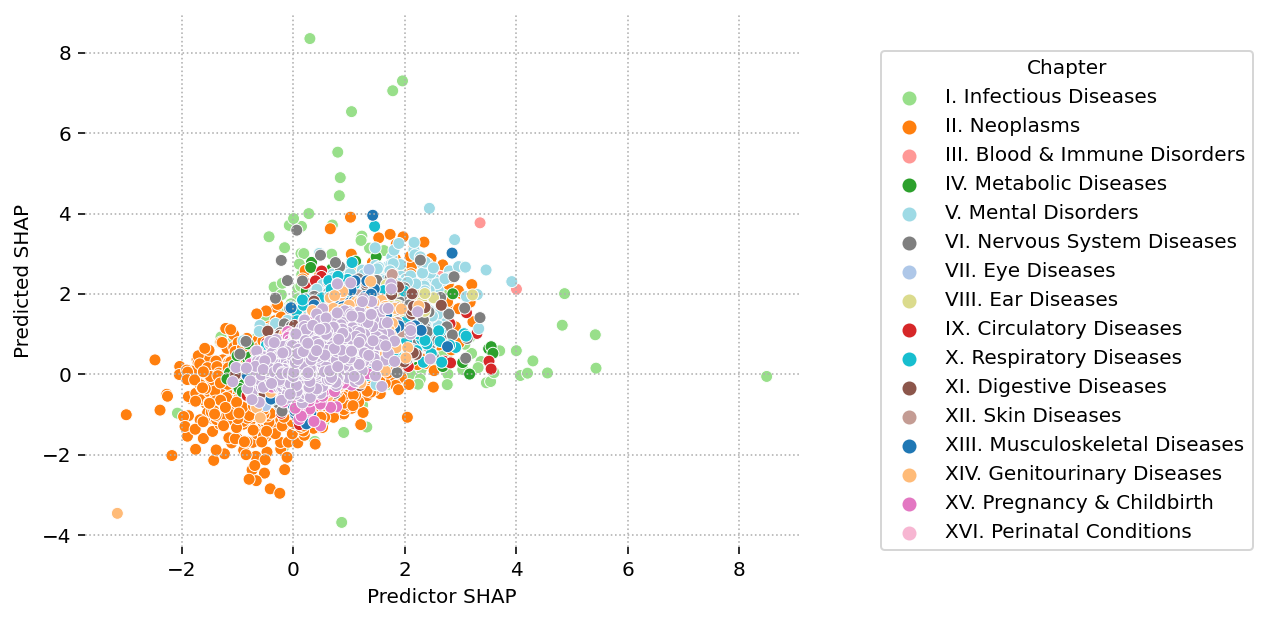

In [23]:
from matplotlib.colors import LogNorm

order = ['I. Infectious Diseases', 'II. Neoplasms',
       'III. Blood & Immune Disorders', 'IV. Metabolic Diseases', 
       'V. Mental Disorders', 'VI. Nervous System Diseases',
       'VII. Eye Diseases', 'VIII. Ear Diseases', 'IX. Circulatory Diseases', 'X. Respiratory Diseases',
       'XI. Digestive Diseases', 'XII. Skin Diseases',
       'XIII. Musculoskeletal Diseases', 'XIV. Genitourinary Diseases',
       'XV. Pregnancy & Childbirth', 'XVI. Perinatal Conditions',]

ddf = pd.DataFrame({'x': df_shap_agg_sim_x, 'y': df_shap_agg_sim_y, 'c': colours, 'Chapter': chapters})

sns.scatterplot(data=ddf, x='x', y='y', hue='Chapter', 
           palette=color_mapping, hue_order=order)
plt.xlabel('Predictor SHAP')
plt.ylabel('Predicted SHAP')
plt.gca().legend_.set_bbox_to_anchor((1.1, 0.95))
plt.show()

In [24]:
np.mean(coeffs)

0.5228192102301437

###  Time-resolved SHAP analysis

In [32]:
import textwrap
from tqdm import tqdm

def wrap(txt, width=30):
    segments = textwrap.wrap(txt, width)
    return '\n'.join(segments)

In [33]:
d = get_batch(range(len(np.unique(shap_pkl['people']))), val, val_p2i,  
              select='center', block_size=48, 
              device='cpu', padding='regular')

In [34]:
has_gender = torch.isin(d[0], torch.tensor([2, 3])).any(dim=1).numpy()
is_male = torch.isin(d[0], torch.tensor([3])).any(dim=1).numpy()
is_female = torch.isin(d[0], torch.tensor([2])).any(dim=1).numpy()

In [35]:
def get_person(idx):
    x, y, _, time = get_batch([idx], val, val_p2i,  
              select='center', block_size=48, 
              device=device, padding='regular')
    x, y = x[y > -1], y[y > -1]
    person = []
    for token_id, date in zip(x, y):
        person.append((id_to_token[token_id.item()], date.item()))
    return person, y, time[0][-1]

In [36]:
persons_lengths = []
ages = []
reg_times = []

for p in tqdm(np.unique(shap_pkl['people'])):
    pers = get_person(p)

    reg_time_idx = np.where(np.isin(tokens_to_ids(np.array(pers[0])[:, 0]), np.arange(4, 13)))[0]
    if len(reg_time_idx) > 0:
        reg_time = pers[0][reg_time_idx[0]][1]
    else:
        reg_time = -1

    reg_times += [reg_time] * len(pers[0])
    persons_lengths += [p] * len(pers[0])
    ages += [pers[-1].item()] * len(pers[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99988/99988 [02:11<00:00, 760.71it/s]


In [37]:
len(ages) == len(df_shap)

True

In [38]:
all_tokens = shap_pkl['tokens']
all_values = shap_pkl['values']
all_times = shap_pkl['times']

df_shap = pd.DataFrame(all_values)
df_shap['token'] = all_tokens
df_shap['time'] = all_times
df_shap['person'] = shap_pkl['people']
df_shap['age'] = np.array(ages) / 365.25
df_shap['reg_time_years'] = np.array(reg_times) / 365.25

df_shap['Time, years'] = df_shap['time'] / 365.25
df_shap['age_at_token'] = df_shap['age'] - df_shap['time'] / 365.25

df_shap = df_shap[df_shap['reg_time_years'] > 0]

In [39]:
token_count_dict = df_shap['token'].value_counts().sort_index().to_dict()

In [40]:
import numpy as np

def filter_bins(x, y, n=5, grid_size=3):
    '''Filter out regions wiht few data points'''
    x, y = np.array(x), np.array(y)
    
    bin_edges = np.arange(np.min(x), np.max(x), grid_size)        
    bin_indices = np.digitize(x, bin_edges)

    bin_counts = np.array([np.sum(bin_indices == i) for i in range(1, len(bin_edges)+1)])
    valid_bins = np.where(bin_counts >= n)[0] + 1

    valid_indices = np.isin(bin_indices, valid_bins)
    x_filtered = x[valid_indices]
    y_filtered = y[valid_indices]

    return x_filtered, y_filtered


In [41]:
import numpy as np

def bins_avg(x, y, grid_size=3):
    '''Filter out regions wiht few data points'''
    x, y = np.array(x), np.array(y)
    
    bin_edges = np.arange(np.min(x), np.max(x), grid_size)

    bin_indices = np.digitize(x, bin_edges)
    bin_avgs = np.array([y[bin_indices == i].mean() for i in range(1, len(bin_edges)+1)])

    return bin_edges, bin_avgs


In [42]:
import numpy as np
import statsmodels.api as sm

def lowess_regression(x, y, delta=0):
    """
    Perform Lowess regression on two numpy arrays, x and y, 
    and return function values over a fixed grid.

    Parameters:
    x (numpy array): Independent variable data.
    y (numpy array): Dependent variable data.

    Returns:
    numpy array: Computed Lowess values on a fixed grid.
    """

    x, y = np.array(x), np.array(y)
    grid = np.linspace(np.min(x), np.max(x), 100)
    
    lowess = sm.nonparametric.lowess(y, x, delta=delta)
    lowess_on_grid = np.interp(grid, lowess[:, 0], lowess[:, 1])

    return grid, lowess_on_grid

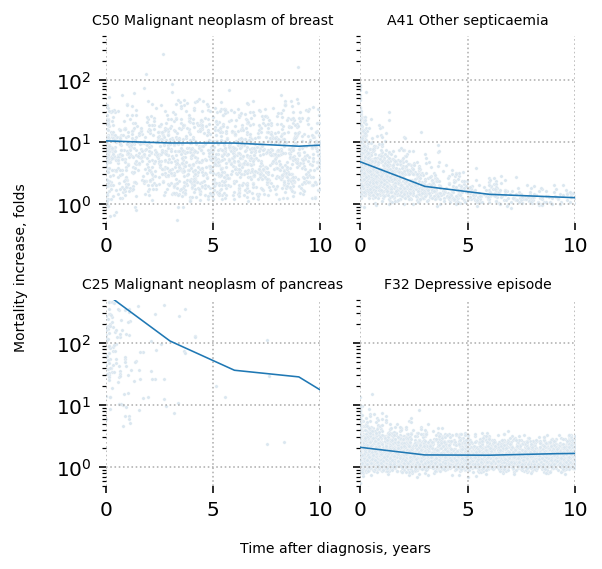

In [43]:
idxs_of_interest = [1188, 46, 1168, 305]

palette_faint = [sns.color_palette("Paired")[0], sns.color_palette("Paired")[2], sns.color_palette("Paired")[4]]
palette_bright = [sns.color_palette("Paired")[1], sns.color_palette("Paired")[3], sns.color_palette("Paired")[5]]

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(4, 3.8), sharey=True, sharex=False)
axs = axs.flatten()

for ax, idx in zip(axs, idxs_of_interest):
        traits = labels.loc[[idx]]
        df_trait = df_shap[df_shap['token'].isin(traits.index)].copy()
        df_trait['Time, years'] = df_trait['time'] / 365.25
        df_trait['Bracket'] = df_trait['token'].map(id_to_token)
        df_trait[1269] = np.exp(df_trait[1269])
        
        # Scatterplot configuration
        sns.scatterplot(data=df_trait, x='Time, years', y=1269, ax=ax, alpha=1, color='#DBE7F0', label=wrap(id_to_token[idx], width=15), 
                        legend=None, s=3, rasterized=True)
        ax.set_title(wrap(delphi_labels.loc[idx, 'name'], width=60), size=7)

        # Regression plot configuration
        x, y = df_trait['Time, years'], df_trait[1269]
        n = 3

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            x, y = bins_avg(x, y, grid_size=n)
        
        ax.plot(x, y, color=palette_bright[0], linewidth=0.8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yscale('log')
        # ax.tick_params(length=1, width=0.5, labelsize=4, grid_alpha=0.65, grid_linewidth=0.45)
        # ax.tick_params(which='minor', length=0.5, width=0.3, labelsize=4, grid_alpha=0.65, grid_linewidth=0.45)
        ax.set_xlim(0, 10)


        # ax.set_xlim(None, [70, 20, 40][col]) 

ax.set_ylim(0.5, 500)
ax.set_xlim(0, 10)
plt.figtext(0.525, -0.02, 'Time after diagnosis, years', size=7, ha='center')
plt.figtext(-0.02, 0.5, 'Mortality increase, folds', size=7, ha='center', va='center', rotation=90)

plt.tight_layout(pad=1.05)  # Adjust the rect parameter as needed

plt.show()

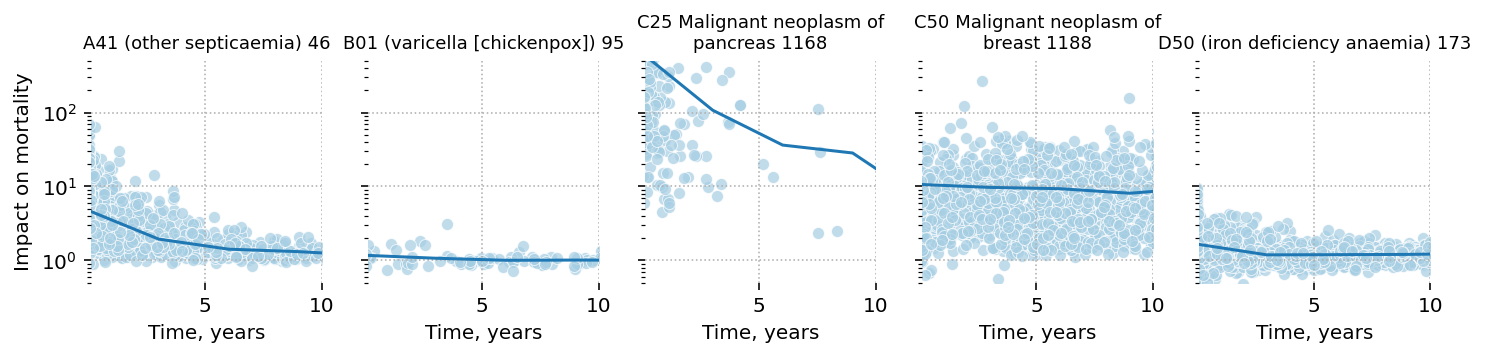

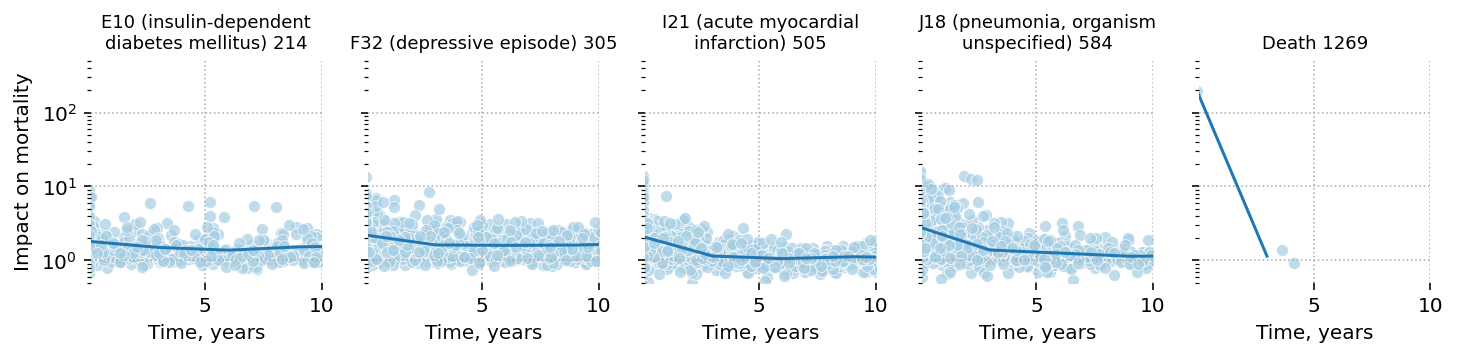

In [44]:
tokens_of_interest = [46, 95, 1168, 1188, 173, 214, 305, 505, 584, 1269]
n_groups = len(tokens_of_interest) // 5

for num_g, token_group in enumerate(np.array_split(tokens_of_interest, n_groups)):

    fig, axs = plt.subplots(1, 5, figsize=(12, 2), sharey=True)
    
    for num, (ax, token_id) in enumerate(zip(axs.flatten(), token_group)):
        df_trait = df_shap[df_shap['token'] == token_id].copy()
        df_trait[1269] = np.exp(df_trait[1269].values)
        df_trait['Time, years'] = df_trait['time'] / 365.25
        df_trait = df_trait.head(2000)
        if len(df_trait) < 2:
            continue

        sns.scatterplot(data=df_trait, x='Time, years', y=1269, ax=ax, color=palette_faint[0], alpha=0.7, rasterized=True)

        x, y = df_trait['Time, years'], df_trait[1269]
        n = 3

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            x, y = bins_avg(x, y, grid_size=n)
        
        ax.plot(x, y, color=palette_bright[0], linewidth=1.5)

        ax.set_ylim(0.5, 500)
        ax.set_xlim(0.1, 10)
        ax.set_ylabel('Impact on mortality');
        ax.set_title(wrap(id_to_token[token_id]) + f' {token_id}', size=9)
        # ax.set_xscale('log')
    
    ax.set_yscale('log')
    plt.show()


## Interaction heatmap

In [45]:
df_shap

0             1             2             3             4  \
46       2.117188e+00 -3.092957e-02  3.312500e+00 -4.125977e-02  1.071289e+00   
47       4.768372e-07 -0.000000e+00  0.000000e+00  1.192093e-07  7.152557e-07   
48       4.768372e-07 -0.000000e+00  0.000000e+00  1.192093e-07 -3.576279e-07   
49       4.768372e-07 -0.000000e+00  0.000000e+00  1.192093e-07 -3.576279e-07   
50       4.768372e-07 -0.000000e+00  0.000000e+00  1.192093e-07 -3.576279e-07   
...               ...           ...           ...           ...           ...   
2532589  1.845703e-01 -5.111694e-02  4.023438e-01  4.284668e-01  1.383972e-02   
2532590  1.823730e-01 -4.199219e-02  4.978027e-01  2.030029e-01  3.078613e-01   
2532591  2.214050e-02 -4.525757e-02  4.208374e-02  1.887512e-02 -1.195679e-01   
2532592  9.536743e-07  5.960464e-08 -5.960464e-07  1.192093e-07  0.000000e+00   
2532593  4.906250e+00 -3.060913e-02  5.605469e+00  6.363281e+00 -6.805420e-02   

                    5             6             7             8             9  \
46       1.430664e+00  1.700195e+00  1.361328e+00  9.536133e-01  9.869385e-02   
47       1.192093e-07 -1.192093e-07  7.152557e-07 -4.768372e-07  0.000000e+00   
48       1.192093e-07 -1.192093e-07  0.000000e+00 -4.768372e-07 -3.576279e-07   
49       1.192093e-07 -1.192093e-07  0.000000e+00 -4.768372e-07 -3.576279e-07   
50       1.192093e-07 -1.192093e-07  0.000000e+00 -4.768372e-07 -3.576279e-07   
...               ...           ...           ...           ...           ...   
2532589  2.490234e-02  1.523438e-01  6.787109e-02  1.308594e-01  9.466553e-02   
2532590  6.628418e-02 -2.619629e-01 -3.466797e-02  3.527832e-02 -6.292725e-02   
2532591 -1.231079e-01 -7.360840e-02 -1.311035e-01 -9.515381e-02 -2.396240e-01   
2532592 -2.384186e-07 -4.768372e-07  0.000000e+00  3.576279e-07  4.768372e-07   
2532593 -2.832031e-02  4.377441e-01  6.987305e-01  9.038086e-01 -3.056641e-01   

         ...          1267          1268          1269  token      time  \
46       ... -3.708496e-01 -1.524414e+00  8.188477e-01      3  23459.00   
47       ...  0.000000e+00  4.768372e-07  0.000000e+00      1  21632.75   
48       ...  0.000000e+00 -2.384186e-07  0.000000e+00      1  19806.50   
49       ...  0.000000e+00 -2.384186e-07  0.000000e+00      1  17980.25   
50       ...  0.000000e+00 -2.384186e-07  0.000000e+00      1  16154.00   
...      ...           ...           ...           ...    ...       ...   
2532589  ...  4.165649e-02  6.780624e-04  2.052002e-01     10    595.00   
2532590  ...  2.919006e-02  2.900391e-01  2.404785e-02      5    595.00   
2532591  ...  6.280518e-02  1.097412e-01  4.315186e-02      7    595.00   
2532592  ...  2.384186e-07 -1.192093e-07  5.960464e-07      1    530.50   
2532593  ...  5.195312e-01 -5.502930e-01  3.859863e-01    499      0.00   

         person        age  reg_time_years  Time, years  age_at_token  
46            1  64.227242       58.442163    64.227242      0.000000  
47            1  64.227242       58.442163    59.227242      5.000000  
48            1  64.227242       58.442163    54.227242     10.000000  
49            1  64.227242       58.442163    49.227242     15.000000  
50            1  64.227242       58.442163    44.227242     20.000000  
...         ...        ...             ...          ...           ...  
2532589   99999  51.452430       49.823409     1.629021     49.823409  
2532590   99999  51.452430       49.823409     1.629021     49.823409  
2532591   99999  51.452430       49.823409     1.629021     49.823409  
2532592   99999  51.452430       49.823409     1.452430     50.000000  
2532593   99999  51.452430       49.823409     0.000000     51.452430  

[2511333 rows x 1277 columns]

In [46]:
N_min = 5

token_count_dict_below_5y = df_shap[df_shap['Time, years'] < 5]['token'].value_counts().sort_index().to_dict()
token_count_dict_over_10y = df_shap[df_shap['Time, years'] > 10]['token'].value_counts().sort_index().to_dict()

for d in [token_count_dict_below_5y, token_count_dict_over_10y]:
    for i in range(1300):
        if i not in d:
            d[i] = 0

columns_more_N = [c for c in df_shap.columns if c == 1269 or(c in token_count_dict_below_5y and token_count_dict_below_5y[c] >= N_min and 
                                                             c in token_count_dict_over_10y and token_count_dict_over_10y[c] >= N_min)]
df_shap_agg_below_5y = df_shap[df_shap['token'].apply(lambda x: x in columns_more_N) * (df_shap['Time, years'] < 5)].groupby('token').mean()[columns_more_N]
df_shap_agg_over_10y = df_shap[df_shap['token'].apply(lambda x: x in columns_more_N) * (df_shap['Time, years'] > 10)].groupby('token').mean()[columns_more_N]

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.


In [47]:
def get_tick_coords(arr):
    return np.where(arr[1:] != arr[:-1])[0]

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


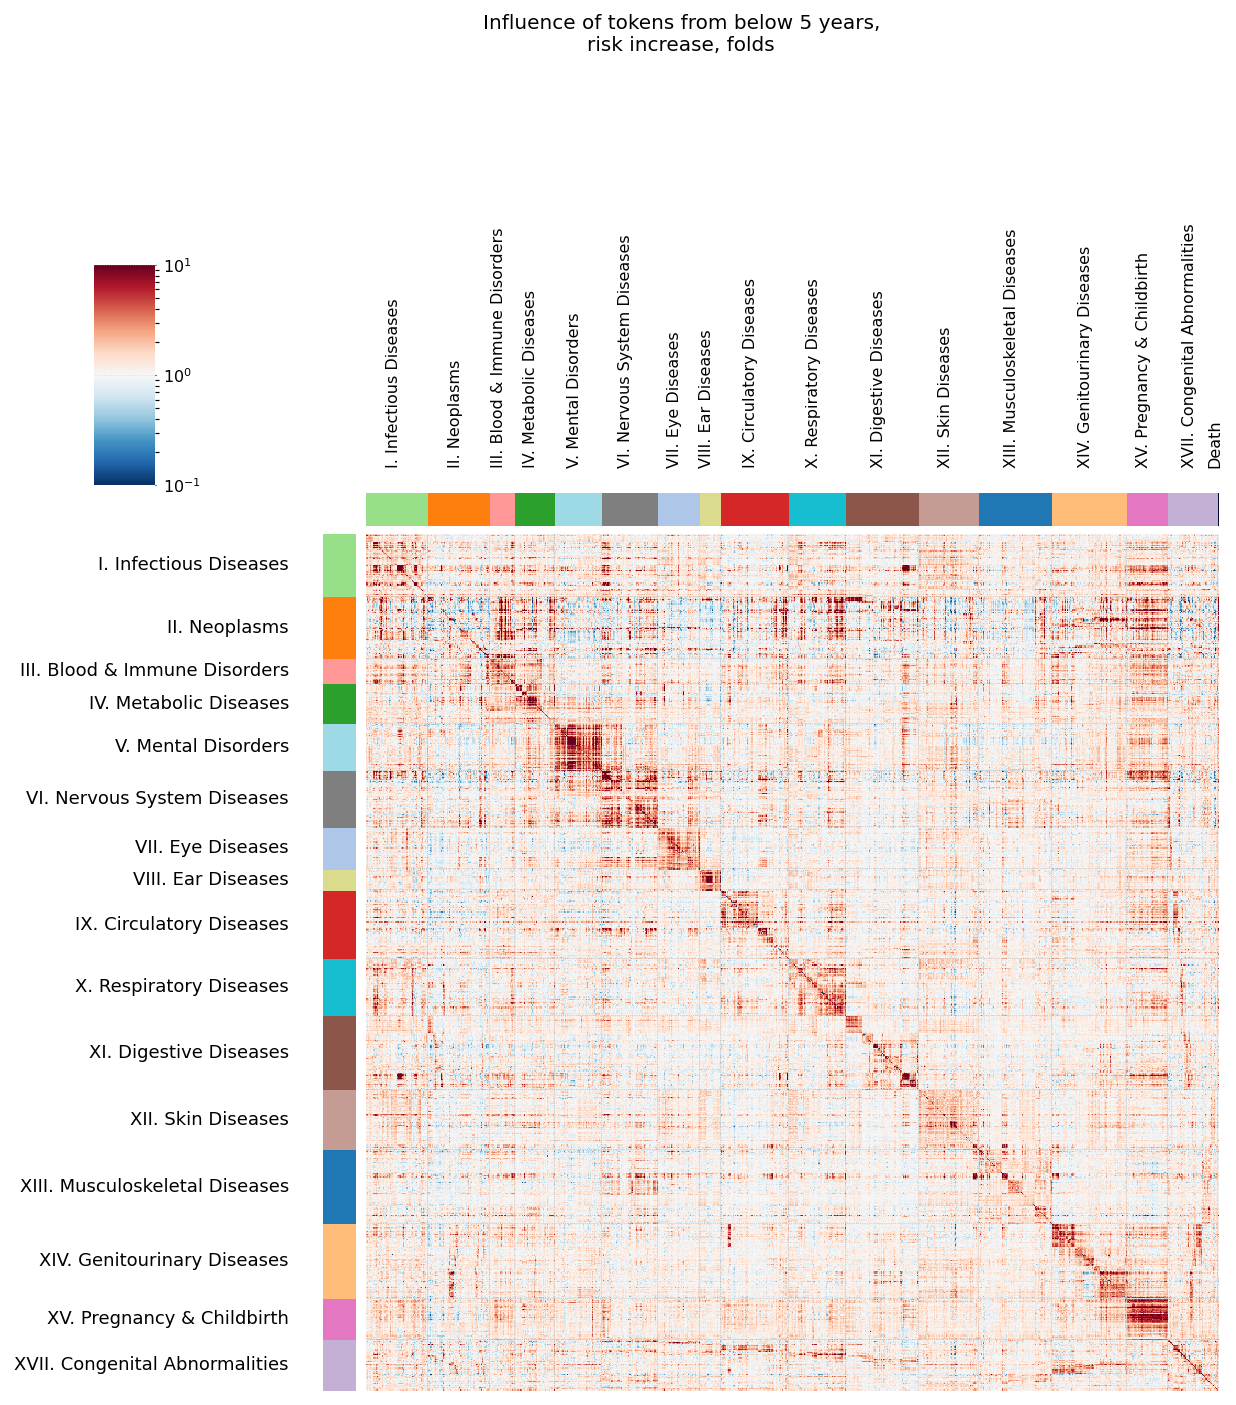

In [48]:
from matplotlib.colors import LogNorm

cur_df = df_shap_agg_below_5y

new_death_rows = 0
for c in range(1269+1, 1269+new_death_rows+1):
    cur_df[c] = cur_df[1269]
delphi_labels = pd.read_csv("delphi_labels_chapters_colours_icd.csv", index_col=0)
death_df = delphi_labels[delphi_labels['ICD-10 Chapter (short)']=="Death"].sample(new_death_rows, replace=True)
death_df['name'] = death_df['name'].apply(lambda x: x + str(np.random.randint(0, 100000)))
death_df.index = pd.Index(range(1269+1, 1269+new_death_rows+1))
delphi_labels = pd.concat([delphi_labels, death_df])

to_exclude_predicted = ['Technical', 'Smoking, Alcohol and BMI', 'Sex', 'XVI. Perinatal Conditions']
to_exclude_predictor = ['Technical', 'Smoking, Alcohol and BMI', 'Sex', 'XVI. Perinatal Conditions', 'Death']

chapter_order = ['I. Infectious Diseases', 'II. Neoplasms',
                   'III. Blood & Immune Disorders', 'IV. Metabolic Diseases', 
                   'V. Mental Disorders', 'VI. Nervous System Diseases',
                   'VII. Eye Diseases', 'VIII. Ear Diseases', 'IX. Circulatory Diseases', 'X. Respiratory Diseases',
                   'XI. Digestive Diseases', 'XII. Skin Diseases',
                   'XIII. Musculoskeletal Diseases', 'XIV. Genitourinary Diseases',
                   'XV. Pregnancy & Childbirth', 'XVI. Perinatal Conditions',
                   'XVII. Congenital Abnormalities', 'Death']


to_exclude_predicted_idx = delphi_labels[~delphi_labels['ICD-10 Chapter (short)'].isin(to_exclude_predicted)].index
to_exclude_predictor_idx = delphi_labels[~delphi_labels['ICD-10 Chapter (short)'].isin(to_exclude_predictor)].index

to_exclude_predicted_idx = to_exclude_predicted_idx[to_exclude_predicted_idx.isin(cur_df.columns)]
to_exclude_predicted_idx = sorted(to_exclude_predicted_idx, key=lambda x: (chapter_order.index(delphi_labels.loc[x, 'ICD-10 Chapter (short)']), x))
to_exclude_predicted_idx = pd.Index(to_exclude_predicted_idx)

to_exclude_predictor_idx = to_exclude_predictor_idx[to_exclude_predictor_idx.isin(cur_df.index.values)]
to_exclude_predictor_idx = sorted(to_exclude_predictor_idx, key=lambda x: (chapter_order.index(delphi_labels.loc[x, 'ICD-10 Chapter (short)']), x))
to_exclude_predictor_idx = pd.Index(to_exclude_predictor_idx)

cur_df = cur_df.loc[to_exclude_predictor_idx, to_exclude_predicted_idx]

row_colors = delphi_labels.iloc[cur_df.index.values]['color'].to_numpy()
col_colors = delphi_labels.iloc[cur_df.columns]['color'].to_numpy()

y_tick_coords = get_tick_coords(delphi_labels.iloc[cur_df.index.values]['color'].to_numpy())
x_tick_coords = get_tick_coords(delphi_labels.iloc[cur_df.columns]['color'].to_numpy())

g = sns.clustermap(np.exp(cur_df.values), row_cluster=False, col_cluster=False, 
                   row_colors=row_colors, col_colors=col_colors, 
                   # norm=LogNorm(vmin=5e-2, vmax=2e1), 
                   norm=LogNorm(vmin=1e-1, vmax=1e1), 
                   cmap='RdBu_r',
                   figsize=(8.5, 8.5),
                   rasterized=True
                  )

g.ax_heatmap.set_xticks(x_tick_coords)
g.ax_heatmap.set_yticks(y_tick_coords);
g.ax_heatmap.tick_params(length=0, width=0.5, labelsize=8, grid_alpha=0.6, grid_linewidth=0.35, grid_color='gray')
g.ax_cbar.tick_params(length=0.5, width=0.6, labelsize=8, grid_alpha=0.45, grid_linewidth=0.45)

for ch, color in delphi_labels[['ICD-10 Chapter (short)', 'color']].drop_duplicates('color').values:
    col_loc = np.where(col_colors == color)[0].mean()
    g.ax_heatmap.text(col_loc - 10, -60, ch, va='bottom', rotation=90, ha='left', size=8)

    row_loc = np.where(row_colors == color)[0].mean()
    g.ax_heatmap.text(-70, row_loc, ch, va='center', ha='right', size=9)

plt.suptitle('Influence of tokens from below 5 years,\nrisk increase, folds', y=1.185, size=10, x=0.5)
plt.show()

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


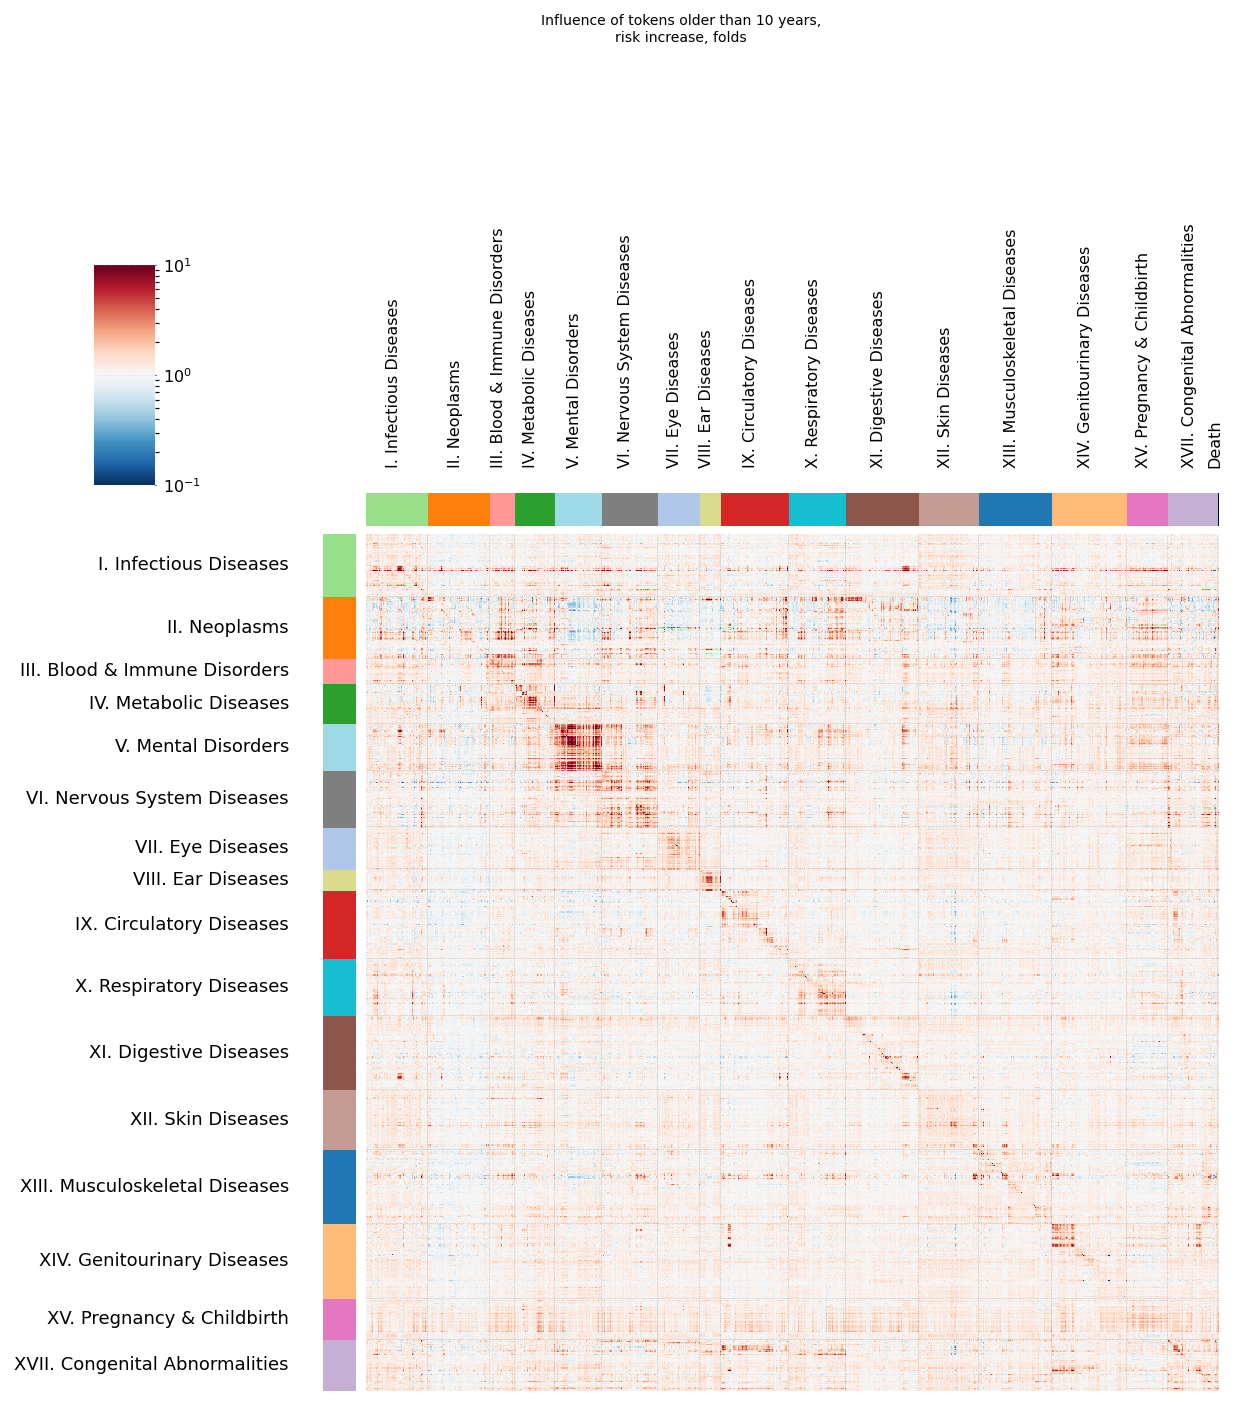

In [49]:
from matplotlib.colors import LogNorm

cur_df = df_shap_agg_over_10y

new_death_rows = 0
for c in range(1269+1, 1269+new_death_rows+1):
    cur_df[c] = cur_df[1269]
delphi_labels = pd.read_csv("delphi_labels_chapters_colours_icd.csv", index_col=0)
death_df = delphi_labels[delphi_labels['ICD-10 Chapter (short)']=="Death"].sample(new_death_rows, replace=True)
death_df['name'] = death_df['name'].apply(lambda x: x + str(np.random.randint(0, 100000)))
death_df.index = pd.Index(range(1269+1, 1269+new_death_rows+1))
delphi_labels = pd.concat([delphi_labels, death_df])

to_exclude_predicted = ['Technical', 'Smoking, Alcohol and BMI', 'Sex', 'XVI. Perinatal Conditions']
to_exclude_predictor = ['Technical', 'Smoking, Alcohol and BMI', 'Sex', 'XVI. Perinatal Conditions', 'Death']

chapter_order = ['I. Infectious Diseases', 'II. Neoplasms',
                   'III. Blood & Immune Disorders', 'IV. Metabolic Diseases', 
                   'V. Mental Disorders', 'VI. Nervous System Diseases',
                   'VII. Eye Diseases', 'VIII. Ear Diseases', 'IX. Circulatory Diseases', 'X. Respiratory Diseases',
                   'XI. Digestive Diseases', 'XII. Skin Diseases',
                   'XIII. Musculoskeletal Diseases', 'XIV. Genitourinary Diseases',
                   'XV. Pregnancy & Childbirth', 'XVI. Perinatal Conditions',
                   'XVII. Congenital Abnormalities', 'Death']


to_exclude_predicted_idx = delphi_labels[~delphi_labels['ICD-10 Chapter (short)'].isin(to_exclude_predicted)].index
to_exclude_predictor_idx = delphi_labels[~delphi_labels['ICD-10 Chapter (short)'].isin(to_exclude_predictor)].index

to_exclude_predicted_idx = to_exclude_predicted_idx[to_exclude_predicted_idx.isin(cur_df.columns)]
to_exclude_predicted_idx = sorted(to_exclude_predicted_idx, key=lambda x: (chapter_order.index(delphi_labels.loc[x, 'ICD-10 Chapter (short)']), x))
to_exclude_predicted_idx = pd.Index(to_exclude_predicted_idx)

to_exclude_predictor_idx = to_exclude_predictor_idx[to_exclude_predictor_idx.isin(cur_df.index.values)]
to_exclude_predictor_idx = sorted(to_exclude_predictor_idx, key=lambda x: (chapter_order.index(delphi_labels.loc[x, 'ICD-10 Chapter (short)']), x))
to_exclude_predictor_idx = pd.Index(to_exclude_predictor_idx)

cur_df = cur_df.loc[to_exclude_predictor_idx, to_exclude_predicted_idx]

row_colors = delphi_labels.iloc[cur_df.index.values]['color'].to_numpy()
col_colors = delphi_labels.iloc[cur_df.columns]['color'].to_numpy()

y_tick_coords = get_tick_coords(delphi_labels.iloc[cur_df.index.values]['color'].to_numpy())
x_tick_coords = get_tick_coords(delphi_labels.iloc[cur_df.columns]['color'].to_numpy())

g = sns.clustermap(np.exp(cur_df.values), row_cluster=False, col_cluster=False, 
                   row_colors=row_colors, col_colors=col_colors, 
                   # norm=LogNorm(vmin=5e-2, vmax=2e1), 
                   norm=LogNorm(vmin=1e-1, vmax=1e1), 
                   cmap='RdBu_r',
                   figsize=(8.5, 8.5),
                   rasterized=True
                  )

g.ax_heatmap.set_xticks(x_tick_coords)
g.ax_heatmap.set_yticks(y_tick_coords);
g.ax_heatmap.tick_params(length=0, width=0.5, labelsize=8, grid_alpha=0.6, grid_linewidth=0.35, grid_color='gray')
g.ax_cbar.tick_params(length=0.5, width=0.6, labelsize=8, grid_alpha=0.45, grid_linewidth=0.45)

for ch, color in delphi_labels[['ICD-10 Chapter (short)', 'color']].drop_duplicates('color').values:
    col_loc = np.where(col_colors == color)[0].mean()
    g.ax_heatmap.text(col_loc - 10, -60, ch, va='bottom', rotation=90, ha='left', size=8)

    row_loc = np.where(row_colors == color)[0].mean()
    g.ax_heatmap.text(-70, row_loc, ch, va='center', ha='right', size=9)


plt.suptitle('Influence of tokens older than 10 years,\nrisk increase, folds', y=1.185, size=7, x=0.5)
plt.show()